In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.EMNIST(root = "~/.pytorch/data/EMNSIT", train=True, download=True, transform=transform, split='letters')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.EMNIST(root = "~/.pytorch/data/EMNSIT", train=False, download=True, transform=transform, split='letters')
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

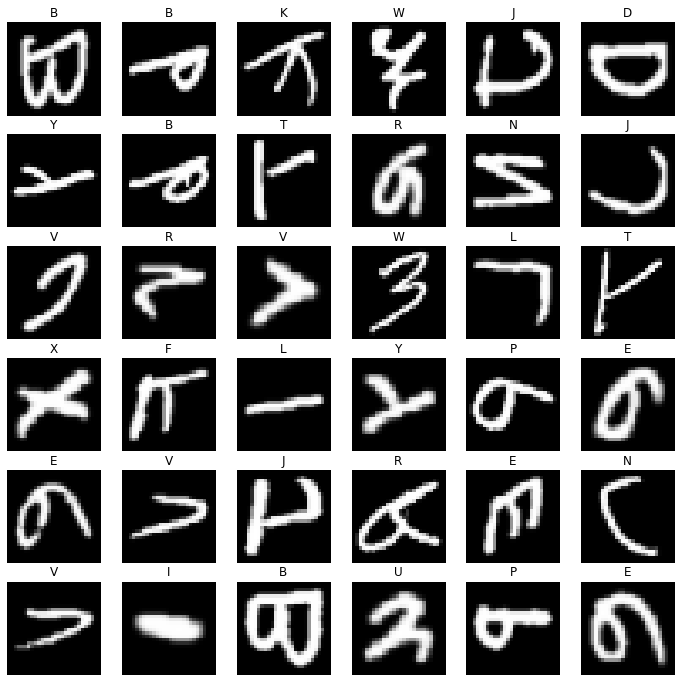

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(6, 6, figsize=(12, 12))  
for i in range(len(ax)): 
    for j in range(len(ax[i])):
        ax[i,j].imshow(images[i * 6 + j].numpy().squeeze(), cmap='Greys_r')
        ax[i,j].set_title(chr(labels[ i * 6 + j].numpy() + 64))
        ax[i,j].axis('off')

In [4]:
def progressBar(e, te, c, t, loss, accuracy):
    cp = c * 50 / t
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.write("Epoch [%3d/%3d] [%s%s] %3.2f %% " % (e, te, '*' * int(cp), '.'*(50 - int(cp)), cp*2))
    sys.stdout.write(" Loss: {:.3f}, Accuracy: {:.3f}".format(loss, accuracy))

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # first conv layer, downsampling layer, and normalization layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d( kernel_size=3, stride=2, padding=1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=2, dilation=1),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=2, dilation=1),
            nn.ReLU(),
            nn.MaxPool2d( kernel_size=3, stride=2)
        )
        
        self.fc_layer_1 = nn.Sequential(
            nn.Linear(in_features=(256 * 2 * 2), out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
        )
        
        self.fc_layer_2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=256, out_features=26),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 2 * 2)  # reduce the dimensions for linear layer input
        x = self.fc_layer_1(x)
        x = self.fc_layer_2(x)
        return self.output_layer(x)

In [6]:
model = Model()
model.cuda()
print(model)

Model(
  (layer1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer_1): Sequ

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
start_epoch = 0
total_epoch = 50
accuracies = []
losses = []

In [8]:
print('Starting training...')
for epoch in range(start_epoch, total_epoch + 1):
    train_loss = 0.0
    train_accuracy = 0.0
    batch = 0
    losses.append(0.0)
    accuracies.append(0.0)
    
    for images, labels in trainloader:
        # Loading Mnsit to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(images) # forward
        loss = criterion(output, labels) # calculate the loss
        loss.backward() # back propagation
        optimizer.step()  # update gradients
        
        # Loss + Accuracy 
        train_loss += loss.item()
        train_accuracy += (torch.argmax(output, dim = 1) == labels).float().sum()
        
        progressBar(epoch, total_epoch, batch, len(trainloader), losses[epoch - 1], accuracies[epoch-1])        
        batch += 1

    losses[epoch] = train_loss / len(trainloader)
    accuracies[epoch] = train_accuracy * 100 / len(trainset)
    
    progressBar(epoch, total_epoch, len(trainloader), len(trainloader), losses[epoch], accuracies[epoch])
    
    if(epoch % 10 == 0):
        state = {'epoch': epoch,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),
                 'seed': seed, 'accuracy': accuracies, 'loss': losses }
        torch.save(state, "emnsit_model.pth")

Starting training...


RuntimeError: cuda runtime error (710) : device-side assert triggered at C:/w/1/s/windows/pytorch/aten/src\THC/generic/THCTensorMath.cu:26

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Train Loss')
ax[1].set_title('Train Accuracy')
ax[0].plot(losses)
ax[1].plot(accuracies)